In [1]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
import torch.nn.utils.prune as prune

C:\Users\reece\AppData\Local\Temp/ipykernel_9128/3404587788.py:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [2]:
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.8
num_steps = 50

In [3]:
# dataloader arguments
batch_size = 128
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
net = nn.Sequential(
                    nn.Linear(28*28,100),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Linear(100,50),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Linear(50,25),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Linear(25,10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True),
                    ).to(device)

In [6]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data.view(batch_size, -1))
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [7]:
# already imported snntorch.functional as SF
loss_fn = SF.ce_rate_loss()

In [8]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [9]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 1
loss_hist = []
acc_hist = []
test_acc_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        acc = SF.accuracy_rate(spk_rec, targets)
        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
        acc_hist.append(acc.item())
        # Test set
        if counter % 50 == 0:
            with torch.no_grad():
                net.eval()

                # Test set forward pass
                test_acc = batch_accuracy(test_loader, net, num_steps)
                print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist.append(test_acc.item())

        counter += 1

Iteration 0, Test Acc: 13.08%

Iteration 50, Test Acc: 69.38%

Iteration 100, Test Acc: 76.29%

Iteration 150, Test Acc: 77.66%

Iteration 200, Test Acc: 81.82%

Iteration 250, Test Acc: 85.74%

Iteration 300, Test Acc: 83.07%

Iteration 350, Test Acc: 89.28%

Iteration 400, Test Acc: 89.09%

Iteration 450, Test Acc: 89.87%



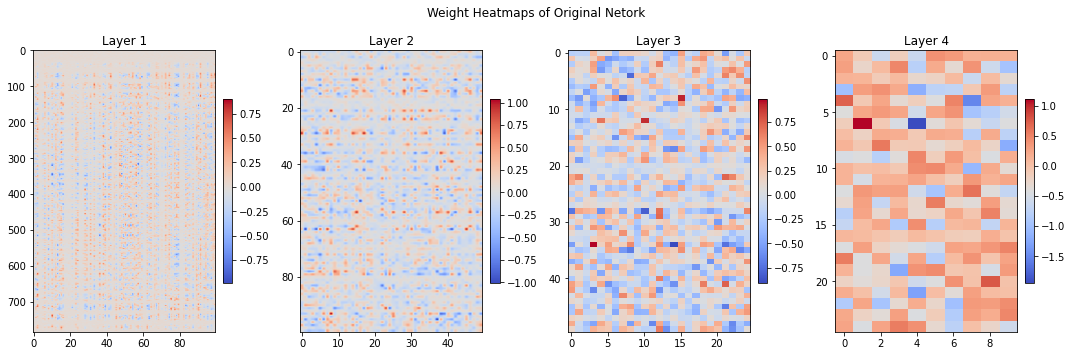

In [10]:
import matplotlib.pyplot as plt

def plot_weight_heatmap(net,subtitle):
    layers = [module for module in net.modules() if isinstance(module, nn.Linear)]

    fig, axes = plt.subplots(nrows=1, ncols=len(layers), figsize=(15, 5))
    fig.suptitle(subtitle)

    for idx, layer in enumerate(layers):
        weight_matrix = layer.weight.detach().cpu().numpy().transpose()
        im = axes[idx].imshow(weight_matrix, cmap='coolwarm', aspect='auto')
        axes[idx].set_title(f'Layer {idx + 1}')
        fig.colorbar(im, ax=axes[idx], orientation='vertical', fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# Visualize Weights
plot_weight_heatmap(net,"Weight Heatmaps of Original Netork")


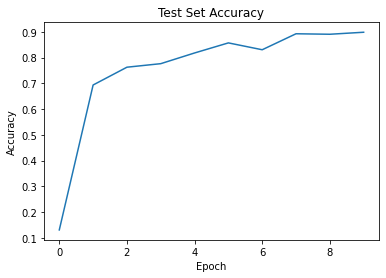

In [11]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

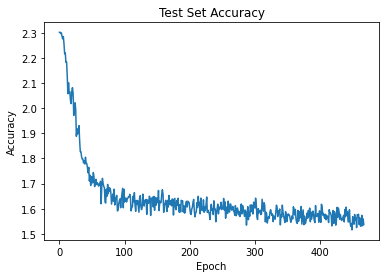

In [12]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(loss_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Simulating the Stroke

In [16]:
class MaskedAdam(torch.optim.Adam):
    def __init__(self, params, masks, lr, **kwargs):
        super(MaskedAdam, self).__init__(params, lr, **kwargs)
        self.masks = masks

    def step(self, closure=None):
        for group, mask_group in zip(self.param_groups, self.masks):
            for p, m in zip(group['params'], mask_group):
                if p.grad is None or m is None:
                    continue

                # Apply weight mask before updating the gradient
                p.grad.data.mul_(m)

        # Call the original step method to update the weights
        super(MaskedAdam, self).step(closure)

def prune_weights(net, pruning_amount=0.5):
    masks = []
    layer_masks = []
    for name, module in net.named_modules():
        if isinstance(module, nn.Linear):
            # Apply L1 unstructured pruning
            prune.random_unstructured(module, name='weight', amount=pruning_amount)

            # Store the mask for the pruned weights
            layer_masks.append(module.weight_mask.clone())

            # Make the pruning permanent
            prune.remove(module, 'weight')
        else:
            layer_masks.append(None)

        if len(layer_masks) == len(net):
            masks.append(layer_masks)
            layer_masks = []

    return masks

# Prune the network and get the masks for pruned weights
masks = prune_weights(net)

# Create the custom optimizer with the pruned weight masks
optimizer = MaskedAdam(net.parameters(), masks, lr=0.001)



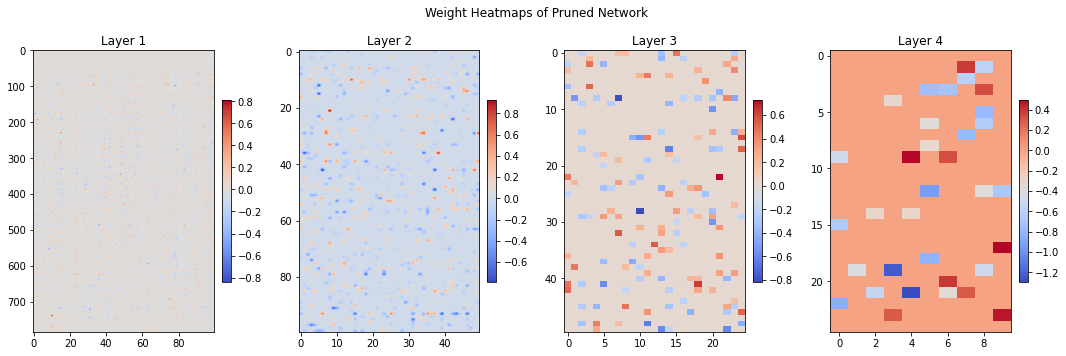

In [17]:
mask = prune_weights(net)
plot_weight_heatmap(net, 'Weight Heatmaps of Pruned Network')

In [18]:
with torch.no_grad():
    net.eval()

    # Test set forward pass
    test_acc_post_prune = batch_accuracy(test_loader, net, num_steps)
    print(f"Iteration {counter}, Test Acc: {test_acc_post_prune * 100:.2f}%\n")

Iteration 468, Test Acc: 16.04%



In [19]:
num_epochs = 1
loss_hist_stroke = []
acc_hist_stroke = []
test_acc_hist_stroke = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        acc = SF.accuracy_rate(spk_rec, targets)
        # Store loss history for future plotting
        loss_hist_stroke.append(loss_val.item())
        acc_hist_stroke.append(acc.item())
        # Test set
        if counter % 50 == 0:
            with torch.no_grad():
                net.eval()

                # Test set forward pass
                test_acc = batch_accuracy(test_loader, net, num_steps)
                print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist_stroke.append(test_acc.item())

        counter += 1

Iteration 0, Test Acc: 17.40%

Iteration 50, Test Acc: 42.69%

Iteration 100, Test Acc: 51.69%

Iteration 150, Test Acc: 72.08%

Iteration 200, Test Acc: 73.34%

Iteration 250, Test Acc: 73.66%

Iteration 300, Test Acc: 74.16%

Iteration 350, Test Acc: 81.14%

Iteration 400, Test Acc: 83.75%

Iteration 450, Test Acc: 84.09%



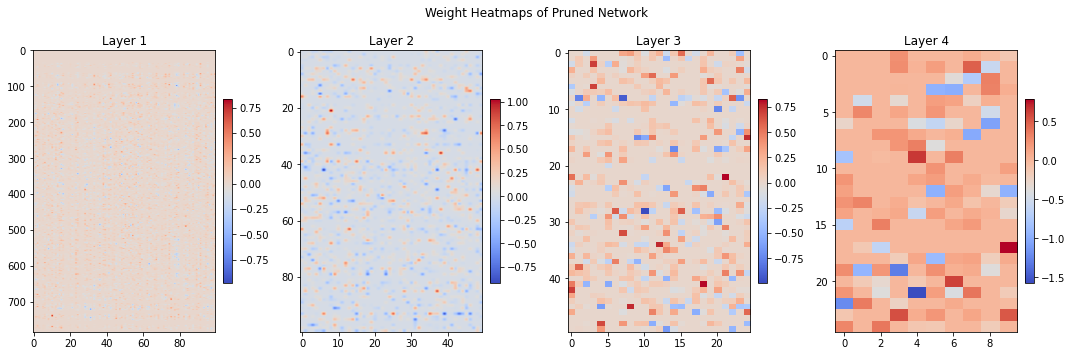

In [20]:
plot_weight_heatmap(net,'Weight Heatmaps of Pruned Network')